# Simple Particle Simulator

Assume we have $N$ particles with strength $k_j > 0$ at the positions $x_j\in\mathbb{R}^2$, $j=0,\dots, N-1$. Each particle creates a potential at a given point $x$ of strength $V_j(x) = -k_j\log |x-x_j|$. The total potential at a given position $x$ is therefore
$$
V(x) = -\sum_{j=0}^{N-1}k_j\log|x-x_j|.
$$

The following code generates $N$ particle positions and a vector of associated strengths.

In [1]:
!conda install -c conda-forge --yes --verbose pyopencl pocl

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /home/nbuser/anaconda3_420:

The following NEW packages will be INSTALLED:

    appdirs:      1.4.3-py_1            conda-forge
    clangdev:     6.0.1-default_1       conda-forge
    libhwloc:     2.0.2-0               conda-forge
    libtool:      2.4.6-h14c3975_1002   conda-forge
    llvm-meta:    6.0.1-0               conda-forge
    llvmdev:      6.0.1-h6bb024c_1002   conda-forge
    mako:         1.0.7-py_1            conda-forge
    ocl-icd:      2.2.12-h14c3975_1002  conda-forge
    pocl:         1.2-h6bb024c_1002     conda-forge
    pyopencl:     2018.2-py35h81a3be6_1 conda-forge
    pytools:      2019.1-py_0           conda-forge
    readline:     7.0-ha6073c6_4                   
    system:       5.8-2                            

The following packages will be UPDATED:

    conda:        4.3.31-py35_0                     --> 4.5.11-py35_0           conda-

In [2]:
import numpy as np
from numba import jit

N = 100  # Number of particles

# Generate random state from seed 0
rand = np.random.RandomState(0)
pos = rand.rand(N, 2)  # Particle positions
k = rand.rand(N)  # Potential strengths

In [3]:
import pyopencl as cl
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

We can plot the corresponding particle positions.

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


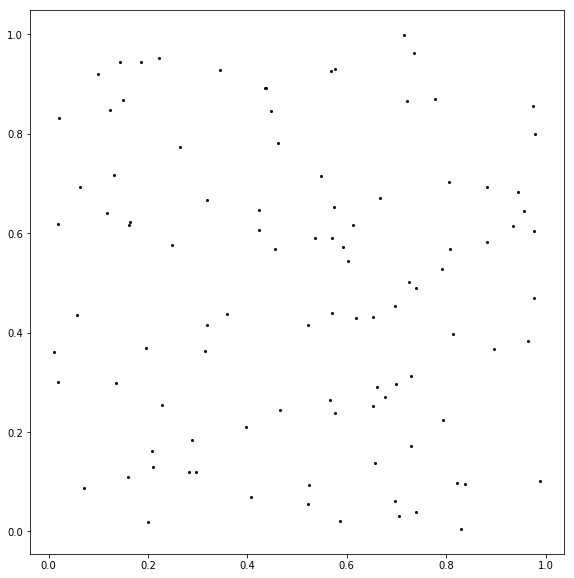

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline  
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(pos[:, 0], pos[:, 1], 'k.', markersize=4)
ax.set_aspect('equal')

The following evaluates the potential field at a given set of points:

In [5]:
def evaluate_field(evaluation_points, source_positions, strength_vector, implementation='numba'):
    """
    Evaluate a field at a given set of points.

    Parameters
    ------------
    evaluation_points : np.ndarray
        A (M, 2) float64 array of M positions that contain the 
        two dimensional points at which to evaluate the field.
    source_positions : np.ndarray
        A (N, 2) float64 array of N source positions that contain
        the source locations
    strength_vector : np.ndarray
        A (N, ) float64 array of the strengths associated with
        each source.
    implementaiton : string
        Either 'numba' or 'opencl' to use a Numba or OpenCL
        implementation.

    Returns
    -------------
    A (M, ) float64 vector of the field values at the corresponding
    evaluation points.

    """

    if implementation == 'numba':
        return np.asarray(evaluate_field_numba(evaluation_points, source_positions, strength_vector))

    elif implementation == 'opencl':
        return np.asarray(evaluate_field_opencl(evaluation_points, source_positions, strength_vector))


@jit(nopython=True)  # Ensures only Numba-supported subset of Numpy is used
def evaluate_field_numba(evaluation_points, source_positions, strength_vector):
    """Numba Implementation"""

    # Result array of total potential at each evaluation point
    evaluation_potentials = []

    for e in range(0, len(evaluation_points)):

        # Cumulative potential at current evaluation point
        running_potential = 0

        for p in range(0, len(source_positions)):

            # Distance between evaluation and particle position
            distance = np.sqrt((evaluation_points[e][0] - source_positions[p][0]) ** 2
                               + (evaluation_points[e][1] - source_positions[p][1]) ** 2)

            # Ensure evalaution and particle position do not coincide to prevent log(0) error
            if distance > 0:
                running_potential -= strength_vector[p] * np.log(distance)

        # Store total potential in result array
        evaluation_potentials.append(running_potential)

    return evaluation_potentials


def evaluate_field_opencl(evaluation_points, source_positions, strength_vector):
    """OpenCL Implementation"""

    kernel = """
    
    __kernel void evaluate_potential(__global double *evaluationPoints,
                                     __global double *sourcePoints,
                                     __global double *strengthVector,
                                     __global double *evaluationPotentials,
                                     const int numberOfParticles)
    {
    
    // Row in evaluationPotentials results array
    int globalRow = get_global_id(0); 
    
    // Initialise variables for intermediate steps in calculations
    double runningPotential = 0; // Cumulative potential at evaluation point
    double distance = 0; // Distance between source and evaluation point
       
    // Iterate through each particle 
    for (int i = 0; i < numberOfParticles; i ++) {

        // Distance between evaluation and source point 
        distance = sqrt(pow(evaluationPoints[2*globalRow] - sourcePoints[2*i], 2) 
                        + pow(evaluationPoints[2*globalRow + 1] - sourcePoints[2*i + 1], 2));
        
        // Check for non-zero distance to prevent log(0) error
        if (distance > 0) {
            runningPotential -= strengthVector[i] * log(distance);
        }
    
    }

    // Store total potential in results array
    evaluationPotentials[globalRow] = runningPotential;

    }
    
    """

    # Number of evaluation and source points 
    n_eval_points = evaluation_points.shape[0]
    n_source_positions = source_positions.shape[0]

    mf = cl.mem_flags

    # Set up buffers 
    eval_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR |
                            mf.READ_ONLY, hostbuf=evaluation_points.ravel())
    source_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR |
                              mf.READ_ONLY, hostbuf=source_positions)
    strength_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | 
                                mf.READ_ONLY, hostbuf=strength_vector)
    result_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR,
                              size=evaluation_points.shape[0] * 8)

    prg = cl.Program(ctx, kernel)
    prg.build()
    potential_kernel = prg.evaluate_potential

    potential_kernel(queue, (n_eval_points, ), (1, ), eval_buffer,
                     source_buffer, strength_buffer, result_buffer, np.int32(N))

    result, _ = cl.enqueue_map_buffer(queue, result_buffer, cl.map_flags.READ, 
                                      0, (n_eval_points, ), np.double)

    queue.finish()

    return result

In [6]:
# Generate test evaluation points
evaluation_points = np.array([[1.5, 1.3], [1.8, 1.6]], dtype='float64')

# Calculate corresponding total potentials using both implementations
result_numba = evaluate_field(evaluation_points, pos, k, implementation='numba')
result_opencl = evaluate_field(evaluation_points, pos, k, implementation='opencl')

print(result_numba)
print(result_opencl)

[-12.04897855 -26.74485914]
[-12.04897855 -26.74485914]


Finally, we want to make timing measurements and also plot the results. Let us define a grid of evaluation points in the unit square.

In [7]:
# Generate 100 by 100 grid of evaluation points within the unit square
Nx = 100
Ny = 100
xpoints, ypoints = np.mgrid[0: 1: 1j * Nx, 0: 1: 1j * Ny]
evaluation_points = np.vstack([xpoints.ravel(), ypoints.ravel()]).T

In [8]:
import time

class Timer:
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

Now run the following two timing experiments:

In [12]:
with Timer() as t:
    result_numba = evaluate_field(evaluation_points, pos, k, implementation='numba')
print(t.interval)

with Timer() as t:
    result_opencl = evaluate_field(evaluation_points, pos, k, implementation='opencl')
print(t.interval)

0.24021077156066895
1.3819949626922607


Finally, we want to plot the results. We plot the logs since the result will be large close to the poles.

In [13]:
result_numba = np.log10(np.abs(result_numba.reshape(Nx, Ny)))
result_opencl = np.log10(np.abs(result_opencl.reshape(Nx, Ny)))

Text(0.5,1,'OpenCL')

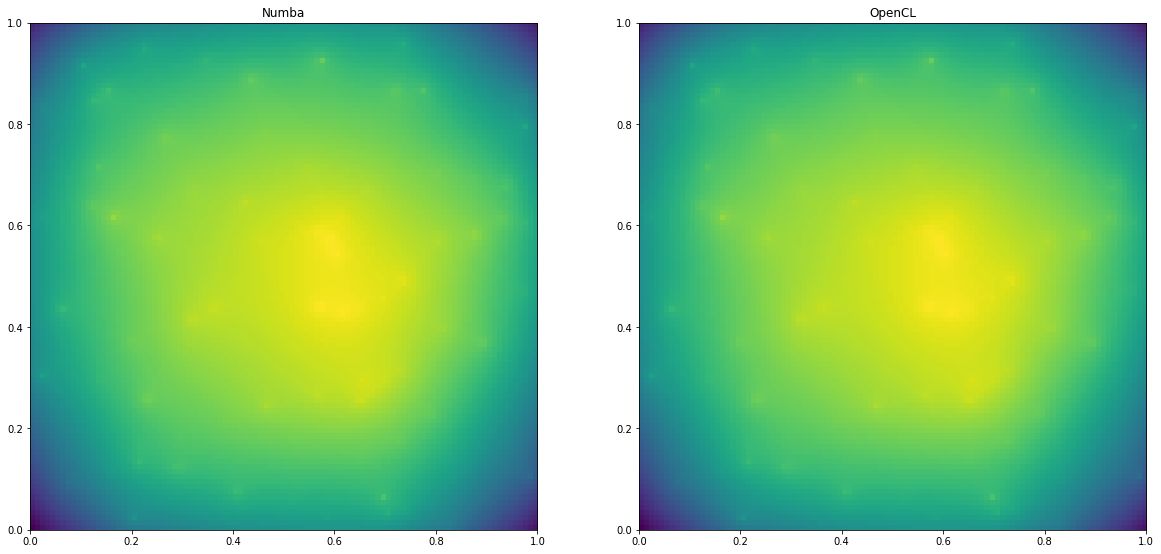

In [14]:
# Set up figures
figure = plt.figure(figsize=(20, 20))
ax1 = figure.add_subplot(121)
ax2 = figure.add_subplot(122)

# Plot Numba results
ax1.imshow(result_numba.T, extent=[0, 1, 0, 1], origin='lower')
ax1.set_aspect('equal')
ax1.set_title('Numba')

# Plot OpenCL results
ax2.imshow(result_opencl.T, extent=[0, 1, 0, 1], origin='lower')
ax2.set_aspect('equal')
ax2.set_title('OpenCL')